# Import packages and load params

In [1]:
import yaml
import sys
import os

## First go back up a folder 
import os
os.chdir('..')
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm
### notebook specific configuration ###
from os.path import basename
#mpl.style.use('ggplot')
mpl.style.use('fivethirtyeight')
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

In [2]:
meta_samples = pd.read_csv('Results/meta_samples.csv',index_col=0)
meta_samples.head()

,Experiment,Full,Short,Short_with_number,Tissue
BMDMwt/GRO/f04_peaks/merge_bg_2.peak,GRO,/data/isshamie/TSS/Processed/BMDMwt/GRO/f04_pe...,BMDMwt_GRO,BMDMwt_GRO1,BMDMwt
Brain/GRO/f04_peaks/merge_bg_2.peak,GRO,/data/isshamie/TSS/Processed/Brain/GRO/f04_pea...,Brain_GRO,Brain_GRO1,Brain
Brain/mSTART/f04_peaks/merge_bg_2.peak,mSTART,/data/isshamie/TSS/Processed/Brain/mSTART/f04_...,Brain_mSTART,Brain_mSTART1,Brain
Heart/mSTART/f04_peaks/merge_bg_2.peak,mSTART,/data/isshamie/TSS/Processed/Heart/mSTART/f04_...,Heart_mSTART,Heart_mSTART1,Heart
Kidney/GRO/f04_peaks/merge_bg_2.peak,GRO,/data/isshamie/TSS/Processed/Kidney/GRO/f04_pe...,Kidney_GRO,Kidney_GRO1,Kidney


## 1.2 Load Parameter file

In [3]:
## Parameters specific to where your folders are and your data
parameter_file = 'params/params.yaml'



with open(parameter_file,'r') as f:
    doc = yaml.load(f)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
#annotation=doc['annotation']
annotation_gtf=doc['annotation_gtf']



## 1.3 Load Developing Modules

In [4]:
from Modules.Homer import *

## 1.4 Print Information

In [5]:
print('Number of tissues: ',len(tissues))

('Number of tissues: ', 16)


# 2. Get Data

### Tissues with totalRNA

In [6]:
tissues_with_RNA = {
    'MiscOrgans': 'Misc',
    'FemaleReproductive':'ReproductiveTract',
    'Brain':'Brain',
    'Lung':'Lung',
    'Liver':'Liver',
    'Spleen':'Spleen',
    'Muscle':'Muscle'    
}

In [20]:
RNA_dir = os.path.join(data_folder,'RNA_Total')


### Helper function to get the tss, input, and rna tag file names

In [8]:
def get_tss_files(data_folder,t,s,RNA_dir):
    '''
    Function to get list of tss,input, and rna tag files. Just deals with the annoying naming
    '''
    if s == 'GRO':
        tss_tag = glob.glob(
            os.path.join(data_folder, t, s, 'f03_tags/') + '/*5GRO*')
        inp_tag = glob.glob(
            os.path.join(data_folder, t, s, 'f03_tags') + '/*_GRO*')
    else:
        tss_tag = glob.glob(
            os.path.join(data_folder, t, s, 'f03_tags/') + '/*_mSTART_*')
        inp_tag = glob.glob(
            os.path.join(data_folder, t, s, 'f03_tags') + '/*mSTARTinput*')

    #Naming is different for CHO
    if t == 'CHO':
        if s == 'GRO':
            tss_tag = glob.glob(
                os.path.join(data_folder, t, s, 'f03_tags/') + '/*5GRO*')
            inp_tag = glob.glob(
                os.path.join(data_folder, t, s, 'f03_tags') + '/*-GRO*')
        else:
            tss_tag = glob.glob(
                os.path.join(data_folder, t, s, 'f03_tags/') + '/*-mSTART-*')
            inp_tag = glob.glob(
                os.path.join(data_folder, t, s, 'f03_tags') + '/*mSTART_input*')
            
    rna_tag = ''
    if t in tissues_with_RNA:
        comb = glob.glob(os.path.join(RNA_dir,'Combined*'+tissues_with_RNA[t]))
        if len(comb) == 1: #glob.glob('Combined*Brain')
            rna_tag = comb[0]
        else:
            rna_tag = glob.glob(os.path.join(RNA_dir,'*' + tissues_with_RNA[t] + '*'))
            rna_tag = (np.array(rna_tag)[map(lambda x: os.path.isdir(x),rna_tag)])[0] #Not the bam but directory

            
    return tss_tag, inp_tag,rna_tag


## Run Homer findcsRNATSS.pl to determine the log2 fold change of tss over input and totalRNA

### Functions for plotting CDF and SDF results

In [9]:
def plot_cdf_rna(exon_peaks,tss_peaks,peaks,name,is_save=True):
    f = plt.figure()
    num_bins = 20
    
    counts, bin_edges = np.histogram (exon_peaks['Log2Ratio vs. RNA'], bins=num_bins, normed=True)
    cdf = np.cumsum (counts)
    plt.plot (bin_edges[1:], cdf/cdf[-1],label='Exon')

    counts, bin_edges = np.histogram (tss_peaks['Log2Ratio vs. RNA'], bins=num_bins, normed=True)
    cdf = np.cumsum (counts)
    plt.plot (bin_edges[1:], cdf/cdf[-1],color='r',label='TSS')

    counts, bin_edges = np.histogram (peaks['Log2Ratio vs. RNA'], bins=num_bins, normed=True)
    cdf = np.cumsum (counts)
    plt.plot (bin_edges[1:], cdf/cdf[-1],color='g',label='TSS')

    plt.legend()
    plt.title(name + ' Log2Ratio Start-seq over Total RNA CDF' )
    if is_save:
        plt.savefig('Results/csRNATSS/Figures/rna_' + name + '.png')
        plt.close()
    return


def plot_cdf_input(exon_peaks,tss_peaks,peaks,name,is_save=True):
    f = plt.figure()
    num_bins = 20
    counts, bin_edges = np.histogram (exon_peaks['Log2Ratio vs. Input'], bins=num_bins, normed=True)
    cdf = np.cumsum (counts)
    plt.plot (bin_edges[1:], cdf/cdf[-1],label='Exon')

    counts, bin_edges = np.histogram (tss_peaks['Log2Ratio vs. Input'], bins=num_bins, normed=True)
    cdf = np.cumsum (counts)
    plt.plot (bin_edges[1:], cdf/cdf[-1],color='r',label='TSS')

    counts, bin_edges = np.histogram (peaks['Log2Ratio vs. Input'], bins=num_bins, normed=True)
    cdf = np.cumsum (counts)
    plt.plot (bin_edges[1:], cdf/cdf[-1],color='g',label='TSS')

    plt.legend()
    plt.title(name + ' Log2Ratio Start-seq over Input CDF' )
    if is_save:
        plt.savefig('Results/csRNATSS/Figures/input_' + name + '.png')
        plt.close()
    return


def plot_sdf_rna(exon_peaks,tss_peaks,peaks,name,is_save=True,num_bins=100):
    f = plt.figure()

    ## Setup bin edges
    num_bins = 100
    concat = np.concatenate((np.array(exon_peaks['Log2Ratio vs. RNA']),np.array(peaks['Log2Ratio vs. RNA'])))
    step = np.ceil(np.ceil(concat.max()) - np.floor(concat.min()))/num_bins
    bins = np.arange(np.floor(concat.min()),np.ceil(concat.max()),step)

    ## Exon peaks
    counts_exon, bin_edges = np.histogram (exon_peaks['Log2Ratio vs. RNA'], bins=bins, density=True)
    cdf_exon = np.cumsum(counts_exon)
    cdf_exon = cdf_exon/cdf_exon[-1]
    sdf_exon = 1-cdf_exon
    plt.plot(bin_edges[1:], sdf_exon,label='Exon')

    ## TSS peaks
    counts_tss, bin_edges = np.histogram (peaks['Log2Ratio vs. RNA'], bins=bins, density=True)
    cdf_tss = np.cumsum(counts_tss)
    cdf_tss = cdf_tss/cdf_tss[-1]
    sdf_tss = 1-cdf_tss
    plt.plot(bin_edges[1:], sdf_tss,color='g',label='TSS')

    plt.plot(bin_edges[1:],sdf_tss-sdf_exon,color='gray',label='Diff')


    plt.legend()
    plt.title(name + ' Log2Ratio Start-seq over Total RNA SDF' )
    
    if is_save:
        plt.savefig('Results/csRNATSS/Figures/SDF_rna_' + name + '.png')
        plt.close()
    return


def plot_sdf_input(exon_peaks,tss_peaks,peaks,name,is_save=True,num_bins=100):
    f = plt.figure()

    ## Setup bin edges
    concat = np.concatenate((np.array(exon_peaks['Log2Ratio vs. Input']),np.array(peaks['Log2Ratio vs. Input'])))
    step = np.ceil(np.ceil(concat.max()) - np.floor(concat.min()))/num_bins
    bins = np.arange(np.floor(concat.min()),np.ceil(concat.max()),step)

    ## Exon peaks
    counts_exon, bin_edges = np.histogram (exon_peaks['Log2Ratio vs. Input'], bins=bins, density=True)
    cdf_exon = np.cumsum(counts_exon)
    cdf_exon = cdf_exon/cdf_exon[-1]
    sdf_exon = 1-cdf_exon
    plt.plot(bin_edges[1:], sdf_exon,label='Exon')

    ## TSS peaks
    counts_tss, bin_edges = np.histogram (peaks['Log2Ratio vs. Input'], bins=bins, density=True)
    cdf_tss = np.cumsum(counts_tss)
    cdf_tss = cdf_tss/cdf_tss[-1]
    sdf_tss = 1-cdf_tss
    plt.plot(bin_edges[1:], sdf_tss,color='g',label='TSS')

    plt.plot(bin_edges[1:],sdf_tss-sdf_exon,color='gray',label='Diff')


    plt.legend()
    plt.title(name + ' Log2Ratio Start-seq over Total Input SDF' )
    
    if is_save:
        plt.savefig('Results/csRNATSS/Figures/SDF_input_' + name + '.png')
        plt.close()
    return

In [10]:
out_f = 'Results/csRNATSS/Brain_trim_CHBrain_5GRO_JHS1036_SD_ATGTCA_S51_L003_R1_001.fastq_trim_CHBrain_GRO_JHS1029_SD_CACCGG_S44_L003_R1_001.fastq'

## Example Case here

In [11]:
t = 'CHO'
s = 'mSTART'
out_dir = 'Results/csRNATSS/Example'


In [12]:
if not os.path.exists(
        os.path.join(data_folder, t, s, 'f04_peaks',
                     'merge_bg_2.peak')):
    print('No folder for this', t, s)
    

## Get file names
tss_tag, inp_tag,rna_tag = get_tss_files(data_folder,t,s,RNA_dir)

## Run findcsRNATSS
out_f = os.path.join(out_dir,t)
for i in tss_tag:
    for j in inp_tag:
        out_name = '%s_%s_%s' % (t,os.path.basename(i),os.path.basename(j))
        out_f = os.path.join(out_dir,out_name) #'Results/csRNATSS/%s_%s_%s' % (t,os.path.basename(i),os.path.basename(j))

        if rna_tag == '':
            cmd = 'findcsRNATSS.pl {start} -i {control} -gtf {annotation_gtf} -genome ch -cpu 30 -o {out_f}'.format(
                start=i,
                control=j,
                annotation_gtf=annotation_gtf,
                out_f=out_f)

        else:
            cmd = 'findcsRNATSS.pl {start} -i {control} -rna {rna} -gtf {annotation_gtf} -genome ch -cpu 30 -o {out_f}'.format(
                start=i,
                control=j,
                rna=rna_tag,
                annotation_gtf=annotation_gtf,
                out_f=out_f)
        print(cmd)
        !{cmd}

findcsRNATSS.pl /data/isshamie/TSS/Processed/CHO/mSTART/f03_tags/trim_CHO--mSTART-JHS823_S21_R1_001.fastq -i /data/isshamie/TSS/Processed/CHO/mSTART/f03_tags/trim_CHO--mSTART_input-JHS802_S11_R1_001.fastq -gtf /data/isshamie/genome/updated_final_sort.gtf -genome ch -cpu 30 -o Results/csRNATSS/Example/CHO_trim_CHO--mSTART-JHS823_S21_R1_001.fastq_trim_CHO--mSTART_input-JHS802_S11_R1_001.fastq
	Fragment Length = 1
	Finding tags on separate strands: doubling effective genome size
	Finding peaks of size 150, no closer than 300
		Finding peaks on picr_0 (minCount=30.1), total tags positions = 284868
		Finding peaks on picr_1 (minCount=30.1), total tags positions = 164643
		Finding peaks on picr_10 (minCount=30.1), total tags positions = 95483
		Finding peaks on picr_100 (minCount=30.1), total tags positions = 23609
		Finding peaks on picr_1000 (minCount=30.1), total tags positions = 2
		Finding peaks on picr_1001 (minCount=30.1), total tags positions = 1
		Finding peaks on picr_1003 (minCoun

		Finding peaks on picr_120 (minCount=30.1), total tags positions = 62100
		Finding peaks on picr_1202 (minCount=30.1), total tags positions = 8
		Finding peaks on picr_1204 (minCount=30.1), total tags positions = 1
		Finding peaks on picr_1208 (minCount=30.1), total tags positions = 1
		Finding peaks on picr_1209 (minCount=30.1), total tags positions = 2
		Finding peaks on picr_121 (minCount=30.1), total tags positions = 6942
		Finding peaks on picr_1210 (minCount=30.1), total tags positions = 4
		Finding peaks on picr_1211 (minCount=30.1), total tags positions = 1
		Finding peaks on picr_1215 (minCount=30.1), total tags positions = 1
		Finding peaks on picr_1219 (minCount=30.1), total tags positions = 1
		Finding peaks on picr_122 (minCount=30.1), total tags positions = 19908
		Finding peaks on picr_1223 (minCount=30.1), total tags positions = 3
		Finding peaks on picr_1225 (minCount=30.1), total tags positions = 1
		Finding peaks on picr_1227 (minCount=30.1), total tags positions = 

		Finding peaks on picr_1490 (minCount=30.1), total tags positions = 36
		Finding peaks on picr_1494 (minCount=30.1), total tags positions = 2
		Finding peaks on picr_1496 (minCount=30.1), total tags positions = 2
		Finding peaks on picr_15 (minCount=30.1), total tags positions = 73719
		Finding peaks on picr_150 (minCount=30.1), total tags positions = 68
		Finding peaks on picr_1500 (minCount=30.1), total tags positions = 673
		Finding peaks on picr_1503 (minCount=30.1), total tags positions = 150
		Finding peaks on picr_1508 (minCount=30.1), total tags positions = 14
		Finding peaks on picr_151 (minCount=30.1), total tags positions = 2801
		Finding peaks on picr_152 (minCount=30.1), total tags positions = 6357
		Finding peaks on picr_1523 (minCount=30.1), total tags positions = 2
		Finding peaks on picr_153 (minCount=30.1), total tags positions = 12183
		Finding peaks on picr_1530 (minCount=30.1), total tags positions = 2
		Finding peaks on picr_1533 (minCount=30.1), total tags posit

		Finding peaks on picr_180 (minCount=30.1), total tags positions = 30
		Finding peaks on picr_1802 (minCount=30.1), total tags positions = 3
		Finding peaks on picr_1803 (minCount=30.1), total tags positions = 1
		Finding peaks on picr_1804 (minCount=30.1), total tags positions = 1
		Finding peaks on picr_1808 (minCount=30.1), total tags positions = 4
		Finding peaks on picr_181 (minCount=30.1), total tags positions = 13
		Finding peaks on picr_182 (minCount=30.1), total tags positions = 1308
		Finding peaks on picr_1821 (minCount=30.1), total tags positions = 1
		Finding peaks on picr_1822 (minCount=30.1), total tags positions = 1
		Finding peaks on picr_1823 (minCount=30.1), total tags positions = 1
		Finding peaks on picr_1826 (minCount=30.1), total tags positions = 1
		Finding peaks on picr_1828 (minCount=30.1), total tags positions = 2
		Finding peaks on picr_183 (minCount=30.1), total tags positions = 4157
		Finding peaks on picr_184 (minCount=30.1), total tags positions = 789
	

		Finding peaks on picr_291 (minCount=30.1), total tags positions = 1
		Finding peaks on picr_292 (minCount=30.1), total tags positions = 12
		Finding peaks on picr_294 (minCount=30.1), total tags positions = 2
		Finding peaks on picr_295 (minCount=30.1), total tags positions = 11
		Finding peaks on picr_296 (minCount=30.1), total tags positions = 6
		Finding peaks on picr_297 (minCount=30.1), total tags positions = 3
		Finding peaks on picr_298 (minCount=30.1), total tags positions = 6
		Finding peaks on picr_299 (minCount=30.1), total tags positions = 65
		Finding peaks on picr_3 (minCount=30.1), total tags positions = 151930
		Finding peaks on picr_30 (minCount=30.1), total tags positions = 26328
		Finding peaks on picr_300 (minCount=30.1), total tags positions = 2
		Finding peaks on picr_301 (minCount=30.1), total tags positions = 44
		Finding peaks on picr_302 (minCount=30.1), total tags positions = 10
		Finding peaks on picr_303 (minCount=30.1), total tags positions = 20
		Findin

		Finding peaks on picr_420 (minCount=30.1), total tags positions = 80
		Finding peaks on picr_421 (minCount=30.1), total tags positions = 2
		Finding peaks on picr_423 (minCount=30.1), total tags positions = 2
		Finding peaks on picr_424 (minCount=30.1), total tags positions = 1
		Finding peaks on picr_425 (minCount=30.1), total tags positions = 1
		Finding peaks on picr_426 (minCount=30.1), total tags positions = 5
		Finding peaks on picr_43 (minCount=30.1), total tags positions = 41703
		Finding peaks on picr_430 (minCount=30.1), total tags positions = 3
		Finding peaks on picr_433 (minCount=30.1), total tags positions = 1
		Finding peaks on picr_434 (minCount=30.1), total tags positions = 3
		Finding peaks on picr_435 (minCount=30.1), total tags positions = 100
		Finding peaks on picr_436 (minCount=30.1), total tags positions = 2
		Finding peaks on picr_438 (minCount=30.1), total tags positions = 3
		Finding peaks on picr_44 (minCount=30.1), total tags positions = 27139
		Finding p

		Finding peaks on picr_570 (minCount=30.1), total tags positions = 4
		Finding peaks on picr_573 (minCount=30.1), total tags positions = 1
		Finding peaks on picr_575 (minCount=30.1), total tags positions = 2
		Finding peaks on picr_576 (minCount=30.1), total tags positions = 5
		Finding peaks on picr_577 (minCount=30.1), total tags positions = 1
		Finding peaks on picr_58 (minCount=30.1), total tags positions = 63329
		Finding peaks on picr_580 (minCount=30.1), total tags positions = 1
		Finding peaks on picr_581 (minCount=30.1), total tags positions = 2
		Finding peaks on picr_582 (minCount=30.1), total tags positions = 2
		Finding peaks on picr_584 (minCount=30.1), total tags positions = 287
		Finding peaks on picr_589 (minCount=30.1), total tags positions = 4
		Finding peaks on picr_59 (minCount=30.1), total tags positions = 65360
		Finding peaks on picr_590 (minCount=30.1), total tags positions = 1
		Finding peaks on picr_591 (minCount=30.1), total tags positions = 616
		Finding 

		Finding peaks on picr_790 (minCount=30.1), total tags positions = 84
		Finding peaks on picr_794 (minCount=30.1), total tags positions = 9
		Finding peaks on picr_795 (minCount=30.1), total tags positions = 1
		Finding peaks on picr_797 (minCount=30.1), total tags positions = 2
		Finding peaks on picr_799 (minCount=30.1), total tags positions = 3
		Finding peaks on picr_7a (minCount=30.1), total tags positions = 39580
		Finding peaks on picr_7b (minCount=30.1), total tags positions = 32116
		Finding peaks on picr_8 (minCount=30.1), total tags positions = 198571
		Finding peaks on picr_80 (minCount=30.1), total tags positions = 11354
		Finding peaks on picr_800 (minCount=30.1), total tags positions = 2
		Finding peaks on picr_801 (minCount=30.1), total tags positions = 1
		Finding peaks on picr_804 (minCount=30.1), total tags positions = 1
		Finding peaks on picr_806 (minCount=30.1), total tags positions = 1
		Finding peaks on picr_807 (minCount=30.1), total tags positions = 3
		Findi

		Tags Used for cluster (less clonal tags) = 20072996.0 / 20072996.0
	Expected tags per peak = 0.752737 (tbp = 0.010036)
	Finding tags on separate strands: doubling effective genome size
		Threshold	Peak Count	Expected Peak Count	FDR	Poisson
		11	41451.000	0.030	7.12e-07	5.53e-10
		10	41451.000	0.434	1.05e-05	8.13e-09
		9	41451.000	5.806	1.40e-04	1.09e-07
		8	41451.000	70.032	1.69e-03	1.31e-06
		7	41451.000	752.627	1.82e-02	1.41e-05
		6	41451.000	7100.343	1.71e-01	1.33e-04
		5	41451.000	57697.398	1.00e+00	1.08e-03
		4	41451.000	393784.433	1.00e+00	7.38e-03
		3	41451.000	2179730.159	1.00e+00	4.09e-02
		2	41451.000	9297534.139	1.00e+00	1.74e-01
		1	41451.000	28209319.223	1.00e+00	5.29e-01
		0	41451.000	53333333.269	1.00e+00	1.00e+00
	41451 peaks passed threshold
	Local Background Filtering: 40487 of 41451 (97.67% passed)
	Total Peaks identified = 40487
	Centering peaks of size 150 using a fragment length of 1
	Analysing TSS initiation patterns 150
	Features that will be considered:
		exo

	Prioritizing Annotations: ...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
	Annotating:.............................................................................................

# Load Result

In [22]:
def load_and_plot(s,t,RNA_dir,data_folder):

    ## Get file names
    tss_tag, inp_tag,rna_tag = get_tss_files(data_folder,t,s,RNA_dir)

    ## Plot results
    count = 1
    for i in tss_tag:
        for j in inp_tag:
            out_name = '%s_%s_%s' % (t,os.path.basename(i),os.path.basename(j))
            out_f = os.path.join(out_dir,out_name) #'Results/csRNATSS/%s_%s_%s' % (t,os.path.basename(i),os.path.basename(j))
            name = '%s_%s_%d' % (t,s,count)

            print('File name: ',out_f)
            if not os.path.exists(out_f + '.tss.txt'):
                continue
            ## Load results of called peaks, tss, and exons
            peaks = pd.read_csv( out_f + '.tss.txt',sep='\t')
            print('Shape of Peaks file: ',peaks.shape)


            exon_peaks = pd.read_csv( out_f + '.annexons.txt',sep='\t')
            tss_peaks = pd.read_csv( out_f + '.anntss.txt',sep='\t')

            ## Plot cdf for Log2 Ratio over input
            plot_cdf_input(exon_peaks,tss_peaks,peaks,name,is_save=False)
            plot_sdf_input(exon_peaks,tss_peaks,peaks,name,is_save=False)

            ## Plot cdf for Log2 Ratio over RNA
            ## Only if RNA sample present
            if not exon_peaks['Log2Ratio vs. RNA'][0] == 'na':
                plot_cdf_rna(exon_peaks,tss_peaks,peaks,name,is_save=False)
                plot_sdf_rna(exon_peaks,tss_peaks,peaks,name,is_save=False)
            count += 1

    peaks.head()
    
    return

('File name: ', 'Results/csRNATSS/Example/CHO_trim_CHO--mSTART-JHS823_S21_R1_001.fastq_trim_CHO--mSTART_input-JHS802_S11_R1_001.fastq')
('Shape of Peaks file: ', (39679, 17))


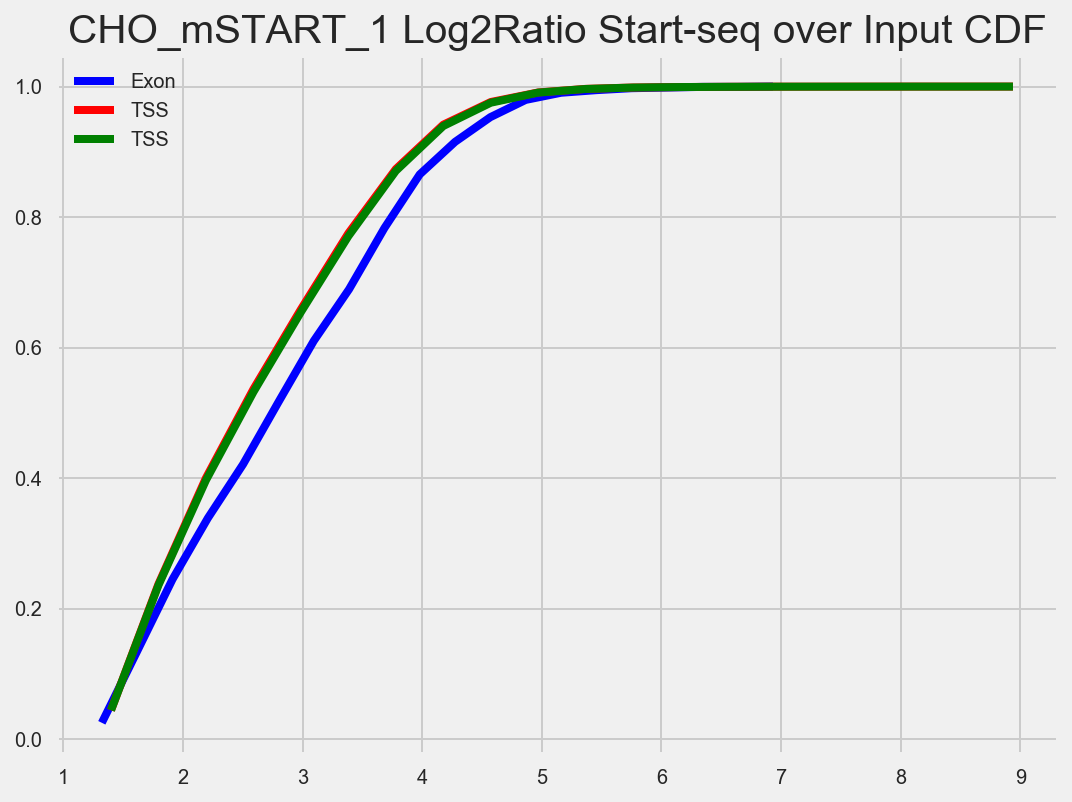

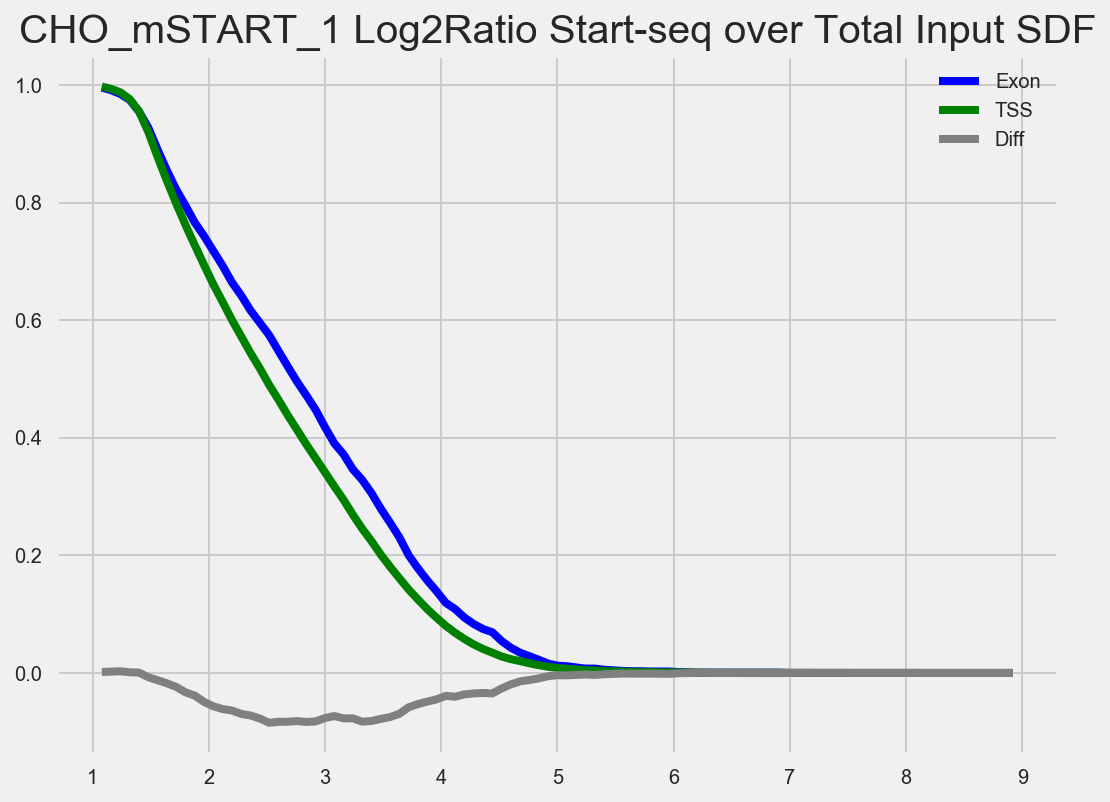

In [23]:
t = 'CHO'
s = 'mSTART'
out_dir = 'Results/csRNATSS/Example'

load_and_plot(s,t,RNA_dir,data_folder)

# Plot Result

## Till Here

In [ ]:
for t in tissues:
    print(t)
    for s in ['GRO', 'mSTART']:
        ## Check if folder was actually processed
        if not os.path.exists(
                os.path.join(data_folder, t, s, 'f04_peaks',
                             'merge_bg_2.peak')):
            print('No folder for this', t, s)
            continue

        ## Get file names
        tss_tag, inp_tag,rna_tag = get_tss_files(data_folder,t,s,RNA_dir)
        
        ## Run findcsRNATSS
        out_f = 'Results/csRNATSS/' + t
        for i in tss_tag:
            for j in inp_tag:
                out_f = 'Results/csRNATSS/%s_%s_%s' % (t,os.path.basename(i),os.path.basename(j))
                
                if rna_f == '':
                    cmd = 'findcsRNATSS.pl {start} -i {control} -gtf {annotation_gtf} -genome ch -cpu 30 -o {out_f}'.format(
                        start=i,
                        control=j,
                        annotation_gtf=annotation_gtf,
                        out_f=out_f)
                
                else:
                    cmd = 'findcsRNATSS.pl {start} -i {control} -rna {rna} -gtf {annotation_gtf} -genome ch -cpu 30 -o {out_f}'.format(
                        start=i,
                        control=j,
                        rna=rna_f,
                        annotation_gtf=annotation_gtf,
                        out_f=out_f)
                print(cmd)
                !{cmd}

In [ ]:
for t in tissues:
    print(t)
    for s in ['GRO', 'mSTART']:
        if not os.path.exists(
                os.path.join(data_folder, t, s, 'f04_peaks',
                             'merge_bg_2.peak')):
            continue
        
        ## Get file names
        tss_tag, inp_tag,rna_tag = get_tss_files(data_folder,t,s,RNA_dir)
        
        ## Plot results
        count = 1
        for i in tss_tag:
            for j in inp_tag:
                out_f = 'Results/csRNATSS/%s_%s_%s' % (t,os.path.basename(i),os.path.basename(j))
                name = '%s_%s_%d' % (t,s,count)
                
                if not os.path.exists(out_f + '.tss.txt'):
                    continue
                ## Load results of called peaks, tss, and exons
                peaks = pd.read_csv( out_f + '.tss.txt',sep='\t')
                print(peaks.shape)
                peaks.head()

                exon_peaks = pd.read_csv( out_f + '.annexons.txt',sep='\t')
                tss_peaks = pd.read_csv( out_f + '.anntss.txt',sep='\t')
                
                ## Plot cdf for Log2 Ratio over input
                plot_cdf_input(exon_peaks,tss_peaks,peaks,name)
                plot_sdf_input(exon_peaks,tss_peaks,peaks,name)
                
                ## Plot cdf for Log2 Ratio over RNA
                ## Only if RNA sample present
                if not exon_peaks['Log2Ratio vs. RNA'][0] == 'na':
                    plot_cdf_rna(exon_peaks,tss_peaks,peaks,name)
                    plot_sdf_rna(exon_peaks,tss_peaks,peaks,name)
                count += 1

# 0. Trim and Align

In [ ]:
in_dir = '/data/isshamie/TSS/Processed/CHO/GRO/'

# 1. Create tags from Bam

# 2. Run findcsRNA

# 3. Plot Results